In [1]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import nilearn.image, nilearn.masking, nilearn.plotting
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import nibabel as nib
import numpy.linalg as linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from PCRegression import PCR
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#!pushd \\10.201.185.39\clmnlab

In [23]:
TM_dir = '/Volumes/clmnlab/TM'
#TM_dir = 'Z:/TM'

behav_dir = TM_dir + '/behav_data/'
roi_dir = TM_dir + '/fMRI_data/masks/Fan/Fan280/'
stats_dir_6 = TM_dir + '/fMRI_data/stats/Reg6_MVPA2_IM_VWM/'
stats_dir_7 = TM_dir + '/fMRI_data/stats/Reg7_MVPA3_IM_COY/'
preproc_dir = TM_dir + '/fMRI_data/preproc_data/'
path_ROI_mask = TM_dir + '/Clust_mask_binary.nii'

subj_list = ["TML04_PILOT","TML05_PILOT","TML06_PILOT","TML07_PILOT", 
            "TML08_PILOT","TML09_PILOT","TML10_PILOT","TML11_PILOT",
            "TML12_PILOT","TML13","TML14","TML15","TML16","TML18","TML19","TML20",
            "TML21","TML22","TML23","TML24","TML25","TML26","TML28","TML29"]
subj = subj_list[0]

freq_range = range(10,20+1,1)
freq_c = freq_range[5]

### Neural data of touching the comparement group

- Freq.index: 비교군이 먼저 오는지, 나중에 오는지  
- LSSout: 한 trial 안에서 beta를 5개씩 구했음  
- 비교군을 만질 때의 neural data를 사용하므로, 비교군이 먼저 온 경우 첫번째 beta, 비교군이 나중에 온 경우 세번째 beta를 선택해야 함(get_label_index_others)  

In [4]:
def calc_freq_class(freq_range, freq):
    #freq_range = range(10,20+1,1)
    freqs = [x for x in freq_range]
    #print(freqs)
    f_mid = int((freqs[0]+freqs[-1])*0.5)
    return int(freq - f_mid)

In [5]:
def get_dataframe(subj, run):
    df = pd.read_csv(behav_dir + subj + '/behav_data_Dis.dat', sep='\t', header=None)
    df.columns=['trial', 'Freq.1', 'ISI1', 'Freq.2', 'ISI2', 'decision', 'correctness', 'RT', 'ISI3']
    df['Freq.1.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.1']]
    df['Freq.2.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.2']]
    df['Freq.other.index'] = [1 if a != 0 else 2 for a in df['Freq.1.class']]
    df['Freq.other.class'] = [a+b for a, b in zip(df['Freq.1.class'], df['Freq.2.class'])]
    df['answer.index'] = [1 if a>b else 2 for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['decision.index'] = [1 if x == 'before' else (2 if x=='after' else 'NaN') for i, x in enumerate(df['decision'])]
    df['Freq.other_decision.class'] = ['NaN' if b=='NaN' else (1 if a==b else -1) for a,b in zip(df['Freq.other.index'],df['decision.index'])]

    df['Freq.1.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.1']]
    df['Freq.2.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.2']]
    df['Freq.other.rank'] = [a+b for a, b in zip(df['Freq.1.rank'], df['Freq.2.rank'])]

    temp = []
    trials = [40, 30, 30]
    fin = -1
    for x in trials:
        ini = fin + 1
        fin = ini + x - 1
        temp.append(df.loc[ini:fin])

    # Note, Freq.other_answer.class == Freq.other_updown.class
    #validation = df['Freq.other_answer.class'] == df['Freq.other.classifier']
    #assert validation.all() == True
    #assert df['Freq.other_decision.class'].shape[0] == sum(trials)
    assert len(temp[run-1]) == trials[run-1]

    return temp[run-1]

In [6]:
def load_freq_all(subj, run):
    df = get_dataframe(subj, run)
    df = pd.DataFrame.reset_index(df)

    temp = [[df.loc[row,'Freq.1'],df.loc[row,'Freq.2']] for row in range(len(df))]
    temp = np.concatenate(temp)
    #temp = pd.DataFrame(temp)

    return temp

In [7]:
def get_label_index(subj, run, num_beta, target_beta):
## labeling betas of others indices ##
## e.g.) ##
## beta_1st, beta_2nd, beta_3rd, beta_4th, beta_5th : nbeta = 5 ##
## freq_before, ISI1, freq_after, ISI2r, Yellow : target_beta = 1 or 3 ##
## others : frequencies which are not equal to center frequency ##
    nbeta = num_beta   # number of betas in one trial
    tb = target_beta   # target_beta, (The index starts from 1)

    list_freq = load_freq_all(subj, run)
    idx_center = []
    idx_other = []
    for r, x in enumerate(list_freq):
        t = r//2            # r = 0, 1, 2, 3, ... // trial >> t = 0, 0, 1, 1, 2, 2, ...
        isbefore = (r+1)%2  # where r is even number means f_before
        isafter = r%2       # where r is odd number means f_after
        
        idx = np.int64( nbeta*t + (tb[0]*isbefore + tb[1]*isafter) - 1 )
        
        if x != freq_c:
            idx_other.append(idx)
        else:
            idx_center.append(idx)

    return idx_center, idx_other

In [8]:
def load_beta_image(subj, run):
## load nilearn image ##
    img = nilearn.image.load_img(stats_dir_6 + '%s/r%02d.LSSout.nii.gz' % (subj, run))
    idx_center, idx_other = get_label_index(subj, run, 5, [1,3])
    img_center = nilearn.image.index_img(img, idx_center)
    img_other = nilearn.image.index_img(img, idx_other)

    return img_center, img_other

In [9]:
def load_target(subj, run):
## load behavior data and make up them ##
    df = get_dataframe(subj, run)
    classifier = list(df['Freq.other.class'])
    regressor = list(df['Freq.other.rank'])

    assert sum(classifier) == 0
    assert sum(regressor) == 0

    return classifier, regressor

In [10]:
def load_target_freq_others(subj):
## load frequencies which are not equal to freq_center sequentially
    df = pd.read_csv(behav_dir + '%s/behav_data_Dis.dat'% subj, sep='\t', header=None)
    freq = list(np.int64(np.where(df[1]!=freq_c,df[1],df[3])))

    return freq

### X & y & grouping

In [11]:
### X: neural data / y: answers / group: run number
def get_X_y_group(subj, runs):      
    cXs = []
    Xs = []
    ys = []
    for run in runs:
        temp_img1, temp_img2 = load_beta_image(subj, run)
        cXs += [temp_img1]
        Xs += [temp_img2]
        temp_c, temp_r = load_target(subj, run)
        ys += [temp_r]

    group = [
        i for i, y in enumerate(ys) for j in range(len(y))
    ]
    Xs = nilearn.image.concat_imgs(Xs)
    cXs = nilearn.image.concat_imgs(cXs)
    ys = np.concatenate(ys)
    
    assert Xs.shape[-1] == ys.shape[0]
    assert ys.shape[0] == len(group)
    return Xs, cXs, ys, group

### ROI Masking
- Group ROI사용

In [12]:
def fast_masking(img, roi):
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)

    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))

    return img_data[roi_mask,:]

In [13]:
roi_path = sorted(glob.glob(roi_dir + 'fan.roi.resam.*.nii.gz'))
roi_imgs = []

for path in roi_path:
    roi_imgs.append(nilearn.image.load_img(path))

### Write nifti images

In [14]:
def write_data_nifti(data, mask_img, fname):
    if len(mask_img.shape)!=3:
        raise ValueError('mask image should be in 3D format')
    mask_img_asarray = mask_img.get_fdata()
    template = np.zeros_like(mask_img_asarray)
    template[np.where(mask_img_asarray==1)]=data
    img_write = nib.Nifti1Image(template, mask_img.affine)
    img_write.to_filename(fname)

### Principal Component Regression

In [15]:
set_nPC = [1,5,10,15,20,25,30,40,50,60]
df=pd.DataFrame(set_nPC,columns=['nPC'])

In [32]:
for subj in subj_list:
    Xs, cXs, ys, group = get_X_y_group(subj, [1,2,3])
    k = len(np.unique(group))
    cv = GroupKFold(k)
    roi = nilearn.image.load_img(path_ROI_mask)

    ## whole brain analysis ##
    #nvoxels = Xs.shape[0]*Xs.shape[1]*Xs.shape[2]
    #ntrials = Xs.shape[3]
    #print(nvoxels,ntrials)
    #temp = Xs.get_fdata().reshape(nvoxels,ntrials)
    #print(temp.shape)
    #XT = temp.T

    ## ROI analysis ##
    temp = fast_masking(img=Xs, roi=roi)
    XT = temp.T
    nvoxels = temp.shape[0]
    rval=[]
    for n_components in set_nPC:
        Ypred = []
        for idx_train, idx_test in cv.split(XT, ys, group):
            # print(Xtrans[idx_test,:].shape,Xtrans[idx_train,:].shape)  >>> (nX*nY*nZ,ntrain)
            # n_components = ntrial
            Xtrain = XT[idx_train,:]
            Ytrain = ys[idx_train]
            pcr = PCR(n_components = n_components)
            pcr.fit(scale(Xtrain),Ytrain)
            Xtest = XT[idx_test,:]  # (ntrials,nvoxels)
            Ypred.append(pcr.predict(scale(Xtest)))
        temp = np.concatenate(Ypred)
        Ypred = temp
        r, _ = stats.pearsonr(Ypred, ys)
        rval.append(r)
    df[subj] = rval

In [50]:
df

,nPC,TML04_PILOT,TML05_PILOT,TML06_PILOT,TML07_PILOT,TML08_PILOT,TML09_PILOT,TML10_PILOT,TML11_PILOT,TML12_PILOT,...,TML19,TML20,TML21,TML22,TML23,TML24,TML25,TML26,TML28,TML29
0,1.0,0.118240,0.065844,0.038105,-0.144724,0.056891,0.115183,-0.108590,-0.159180,-0.129118,...,0.004632,0.056911,0.108360,-0.039148,0.058447,0.074134,-0.157885,-0.069769,-0.236702,-0.027487
1,5.0,0.090453,0.025995,-0.049581,-0.120864,0.115236,0.127877,-0.092831,-0.041002,0.107993,...,0.117306,0.061370,0.129144,-0.020896,0.082257,-0.029919,0.060477,-0.172172,-0.121785,-0.070610
2,10.0,0.137215,-0.004074,-0.005215,-0.123830,-0.038252,0.125980,-0.092961,-0.006941,0.089494,...,0.140144,0.085442,0.085997,0.025126,0.092400,0.010280,-0.038451,-0.181717,-0.076548,0.045254
3,15.0,0.090715,0.014601,-0.009781,-0.076726,-0.059963,0.108269,-0.080206,-0.013003,0.123360,...,0.231404,0.130221,0.084220,0.004402,0.058494,-0.083286,0.015233,-0.223972,0.013739,0.027636
4,20.0,0.057459,0.011191,-0.066224,-0.121907,-0.032885,0.119926,-0.076064,0.014175,0.097267,...,0.206672,0.115531,0.130333,0.019103,0.052701,-0.050372,0.055134,-0.207233,0.072167,0.025091
5,25.0,0.003123,0.040573,-0.085989,-0.143719,0.006813,0.117350,-0.107787,0.000114,0.109663,...,0.232101,0.107168,0.083845,0.019271,0.058095,0.010615,0.063250,-0.172261,0.102410,0.011738
6,30.0,-0.059105,0.036899,-0.089386,-0.143469,0.002697,0.105385,-0.115617,-0.015114,0.106997,...,0.237169,0.109086,0.120567,0.047533,0.097388,0.017050,0.054992,-0.128274,0.122248,0.030368
7,40.0,-0.046012,0.021200,-0.035594,-0.220601,-0.013256,0.118815,-0.124510,-0.042365,0.107274,...,0.224498,0.110887,0.104595,0.063963,0.081342,0.034291,0.122485,-0.144060,0.139871,0.075719
8,50.0,-0.111215,0.043632,-0.039888,-0.208039,-0.018470,0.133924,-0.111000,-0.006941,0.110196,...,0.284434,0.093253,0.094511,0.050113,0.104716,-0.032826,0.140623,-0.130922,0.104389,0.089757
9,60.0,-0.056914,0.069660,-0.005239,-0.151714,-0.012641,0.151855,-0.158996,-0.006096,0.103029,...,0.288503,0.122951,0.147293,0.058577,0.116724,-0.031714,0.122020,-0.145462,0.091388,0.063725


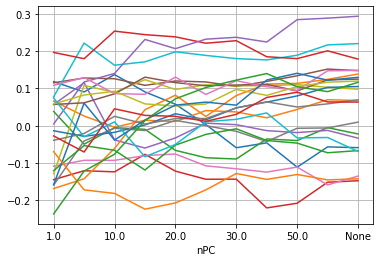

In [51]:
df.plot(x='nPC',legend=None,grid=True)

r value = 0.05745913142114281
0 : 40
40 : 70
70 : 100


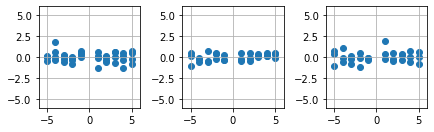

In [18]:
temp = np.concatenate(Ypred)
Ypred = temp
c, _ = stats.pearsonr(Ypred, ys)
print('r value =',c)
fin = 0
for i,idx in enumerate([40,30,30]):
    ini = fin
    fin = ini + idx
    print(ini,':',fin)
    temp_x = ys[ini:fin]
    temp_y = Ypred[ini:fin]
    plt.subplot(1,3,i+1)
    plt.scatter(x=temp_x,y=temp_y)
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

### Principal Component Regression

In [16]:
def run_pcr(X, y, group, mask_img, fname, n_components = [30]):
    k = len(np.unique(group))  ## k = len([0,1,2]) = 3
    cv = GroupKFold(k)
    rval_all = []
    voxel_weights_all = []
#    for nc in np.arange(1,n_components+1):
    for nc in n_components:
        pca = PCA(n_components=nc)  ## fijxed to the number of training data samples
        regr = LinearRegression()
        rval = []
        pval = []
        voxel_weights_temp = []
        for train_index, test_index in cv.split(X, y, group):
            xtrain = X[train_index,:]
            xtest = X[test_index,:]   ## Ntrials by Nvoxels
            ytrain = y[train_index]       ## Ntrials by 1
            ytest = y[test_index] 
            xtrain_pc = pca.fit_transform(scale(xtrain.T)) ## Nvoxels by NPCs
            train_sc = np.matmul(xtrain, xtrain_pc) ## score  ## Ntrials by NPCs
            train_sc_withones = np.concatenate((np.ones((train_sc.shape[0],1)), train_sc), axis=1)  ## Ntrials by NPCs+1
            betas = np.matmul(linalg.pinv(train_sc_withones), ytrain)
            voxel_weights = np.matmul(xtrain_pc, betas[1:])
            ypred = betas[0] + np.matmul(xtest, voxel_weights)
            a, b = stats.pearsonr(ypred, ytest)
            rval.append(a)
            pval.append(b)
            voxel_weights_temp.append(voxel_weights)
        voxel_weights_all.append(1000000*np.mean(voxel_weights_temp,axis=0))
        rval_all.append(np.mean(rval))
        print(f'Processed{nc}th PC, r: {rval_all}')
    opt_nc, best_rval = np.argmax(rval_all), np.max(rval_all)
    voxel_weights_best = np.array(voxel_weights_all[opt_nc])
    write_data_nifti(voxel_weights_best, mask_img, fname)
    return best_rval, opt_nc, rval_all


In [38]:
def run_pcr_new(X, y, group, mask_img, fname, n_components = [60]):
    k = len(np.unique(group))
    cv = GroupKFold(k)
    rval_all = []
    pval_all = []
    voxel_weights_all = []
#    for nc in np.arange(1,n_components+1):
    for nc in n_components:
        pca = PCA(n_components=nc)  ## fixed to the number of training data samples
        regr = LinearRegression()
        #rval = []
        #pval = []
        rval_sum = 0
        voxel_weights_sum = np.zeros(X.shape[1])
        voxel_weights_temp = []
        ypred = np.zeros(len(y))
        
 #       for n, k in enumerate(range(8)):
 #           train_index, test_index = np.where(group==k)[0], np.where(group==7-k)[0]    
#            train_index, test_index = np.where(group==k or group==k+2)[0], np.where(group==7-k or group==)[0]    
        for train_index, test_index in cv.split(X, y, group):
            xtrain = X[train_index,:]
            xtest = X[test_index,:]   ## Ntrials by Nvoxels
            ytrain = y[train_index]       ## Ntrials by 1
            ytest = y[test_index] 
            xtrain_pc = pca.fit_transform(scale(xtrain.T)) ## Nvoxels by NPCs
            train_sc = np.matmul(xtrain, xtrain_pc) ## score  ## Ntrials by NPCs
            train_sc_withones = np.concatenate((np.ones((train_sc.shape[0],1)), train_sc), axis=1)  ## Ntrials by NPCs+1
            betas = np.matmul(linalg.pinv(train_sc_withones), ytrain)
            voxel_weights = np.matmul(xtrain_pc, betas[1:])
            ypred[test_index] = betas[0] + np.matmul(xtest, voxel_weights)
            a, _ = stats.pearsonr(ypred[test_index], ytest)
            rval_sum += a
            #pval.append(b)
            voxel_weights_sum += a*voxel_weights
        voxel_weights_all.append(10000000*voxel_weights_sum/rval_sum)
        #rval_all.append(np.mean(rval))
        rval, pval = stats.pearsonr(ypred, y)
        rval_all.append(rval)
        pval_all.append(pval)
    #    print(f'Processed{nc}th PC, r: {rval}')
    opt_nc, best_rval = np.argmax(rval_all), np.max(rval_all)
    voxel_weights_best = np.array(voxel_weights_all[opt_nc])
    write_data_nifti(voxel_weights_best, mask_img, fname )
    ###nilearn.image.new_img_like(mask, voxel_weights_best)
    return best_rval, opt_nc, rval_all#


In [18]:
y = load_target_freq_others(subj)
fname = f'/Volumes/clmnlab/TM/fMRI_data/MVPA/{subj}_WB_PCR_KF3_No_Centers.nii.gz'  
#a, b, c = run_pcr_new(roi_X, y, group, roi_imgs, fname, n_components = np.arange(1,61))
len(y)

FileNotFoundError: [Errno 2] File b'Z:/TM/behav_data/TML04_PILOT/behav_data_Dis.dat' does not exist: b'Z:/TM/behav_data/TML04_PILOT/behav_data_Dis.dat'

### Whole-brain PCR

In [27]:
#best_r, opt_nc, rval_all = {}, {}, {}
#roi_imgs = nilearn.image.load_img('/Volumes/clmnlab/TM/fMRI_data/masks/full_masks/full_mask.group9.nii')
label_data = '/Users/sskim/Documents/MATLAB/GA/data/fan280_fullname.csv'
roi_label = pd.read_csv(label_data, header=None)
subj_list = ["TML04_PILOT","TML05_PILOT", "TML06_PILOT", "TML07_PILOT", 
             "TML08_PILOT", "TML09_PILOT", "TML10_PILOT", "TML11_PILOT", "TML12_PILOT"]

for subj in subj_list:
    X, cX, _, group = get_X_y_group(subj, [1, 2, 3])
    y = load_target_freq_others(subj) ## frequency values which are not 15 Hz
    roi_imgs = nilearn.image.load_img(preproc_dir + subj + '/preprocessed/full_mask.' + subj + '.nii.gz')
    for r, roi in enumerate(roi_imgs):
        roi_X = fast_masking(roi=roi, img=X)  ## convert 3D-data to 
#    y = load_target_freq_others(subj) ## frequency values which are not 15 Hz
    #fname = f'/Volumes/clmnlab/TM/fMRI_data/MVPA/{subj}_WB_PCR_KF3_No_Centers.nii.gz' 
        if r < 270:
            rval, nc, rval_a = run_pcr_new(roi_X, y, group, roi, fname, n_components = 60)
    #    a, b, c = run_pcr(roi_X, y, group, roi_imgs, fname, n_components = [1])
            best_r[subj, r] = rval
            opt_nc[subj, r] = nc
            rval_all[subj, r] = rval_a
            print(f'Done for {subj}:{roi_label.values[r][0]}, best_r={rval}, opt_nc = {nc}')


In [87]:
roi_imgs = nilearn.image.load_img(preproc_dir + subj + '/preprocessed/full_mask.' + subj + '.nii.gz')
roi_X = fast_masking(roi=roi_imgs, img=X)
np.shape(X)
yy = np.array(y)
for train_index, test_index in cv.split(roi_X.T, y, group):
    print(yy[train_index])

[20 12 18 19 16 14 13 11 10 17 12 19 17 14 13 11 16 18 10 20 13 11 12 10
 17 14 16 19 18 20 16 13 12 20 17 18 14 19 10 11 19 16 18 14 10 13 17 11
 12 20 20 10 13 16 19 11 17 12 18 14]
[13 18 14 10 19 12 17 20 16 11 19 17 10 12 14 18 20 11 16 13 19 12 11 17
 13 14 16 10 20 18 11 10 18 20 13 14 12 16 19 17 20 12 18 19 16 14 13 11
 10 17 12 19 17 14 13 11 16 18 10 20 13 11 12 10 17 14 16 19 18 20]
[13 18 14 10 19 12 17 20 16 11 19 17 10 12 14 18 20 11 16 13 19 12 11 17
 13 14 16 10 20 18 11 10 18 20 13 14 12 16 19 17 16 13 12 20 17 18 14 19
 10 11 19 16 18 14 10 13 17 11 12 20 20 10 13 16 19 11 17 12 18 14]


In [85]:
#cv = GroupKFold(3)
#cv.split(roi_X,y,group)
np.shape(roi_X)
np.shape(X)
#np.shape(roi_imgs)
#np.shape(y)
np.shape(y)
print(y)
#print(y[train_index[:10]])


[13, 18, 14, 10, 19, 12, 17, 20, 16, 11, 19, 17, 10, 12, 14, 18, 20, 11, 16, 13, 19, 12, 11, 17, 13, 14, 16, 10, 20, 18, 11, 10, 18, 20, 13, 14, 12, 16, 19, 17, 20, 12, 18, 19, 16, 14, 13, 11, 10, 17, 12, 19, 17, 14, 13, 11, 16, 18, 10, 20, 13, 11, 12, 10, 17, 14, 16, 19, 18, 20, 16, 13, 12, 20, 17, 18, 14, 19, 10, 11, 19, 16, 18, 14, 10, 13, 17, 11, 12, 20, 20, 10, 13, 16, 19, 11, 17, 12, 18, 14]


TypeError: list indices must be integers or slices, not tuple

In [64]:
rval, nc, rval_a = run_pcr_new(roi_X.T, y, group, roi_imgs, 'temp', n_components = [60])

TypeError: only integer scalar arrays can be converted to a scalar index

In [24]:
roi_label = pd.read_csv(label_data, header=None)
print(roi_label)
X, cX, _, group = get_X_y_group(subj, [1, 2, 3])

                                                  0
0          Lt. superior frontal gyrus (BA8, medial)
1          Rt. superior frontal gyrus (BA8, medial)
2    Lt. superior frontal gyrus (BA8, dorsolateral)
3    Rt. superior frontal gyrus (BA8, dorsolateral)
4         Lt. superior frontal gyrus (BA9, lateral)
..                                              ...
275                             Periaqueductal gray
276                            Lt. substantia nigra
277                            Rt. substantia nigra
278                                 Lt. red nucleus
279                                 Rt. red nucleus

[280 rows x 1 columns]


In [ ]:
subj_list = ["TML04_PILOT","TML05_PILOT", "TML06_PILOT", "TML07_PILOT", 
             "TML08_PILOT", "TML09_PILOT", "TML10_PILOT", "TML11_PILOT", "TML12_PILOT"]
roi_label = pd.read_csv(label_data, header=None)

data = np.zeros((len(subj_list),270))
for s, subj in enumerate(subj_list):
    for r in range(270):
        data[s, r] = best_r[subj, r]
data_df = pd.DataFrame(data, columns=roi_label.values[:270], index = subj_list)
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=data_df, ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.257, ls='--')
ax.set(ylim=(0, 0.6))

In [ ]:
best_r

### Model fitting

In [ ]:
svc_clf = LinearSVC()
results = {}
cv = GroupKFold(3)
decisions_o = {}
decisions_c = {}
for subj in subj_list:
    X, cX, y, group = get_X_y_group(subj, [1, 2, 3])

    for m, roi in enumerate(roi_imgs):
#    for m, roi in enumerate(roi_imgs_short):
        roi_index = m+1
        roi_X = fast_masking(roi=roi, img=X)
        roi_cX = fast_masking(roi=roi, img=cX)
        svc_score = cross_validate(svc_clf, roi_X, y, group, cv=cv,
                                   return_train_score=True, return_estimator=True)
        results[subj, roi_index] = np.mean(svc_score['test_score'])
        #decisions[subj, roi_index] = cross_val_predict(svc_clf, roi_X, y, group, cv=GroupKFold(3),
        #                                                         method="decision_function")
        #print(subj, roi_index, end='\r')
        
        decision_boundary_dist_other = []
        decision_boundary_dist_center = []

        for i, (train_idx, test_idx) in enumerate(cv.split(X=roi_X, groups=group, y=y)):
            decision_boundary_dist_other.append(
                list(svc_score['estimator'][i].decision_function(roi_X[test_idx])))
            
            decision_boundary_dist_center.append(
                list(svc_score['estimator'][i].decision_function(roi_cX[test_idx])))
            
        decision_boundary_dist_other = decision_boundary_dist_other[0] + decision_boundary_dist_other[2] + decision_boundary_dist_other[1]
        decision_boundary_dist_center = decision_boundary_dist_center[0] + decision_boundary_dist_center[2] + decision_boundary_dist_center[1]
        
        decisions_o[subj, roi_index] = decision_boundary_dist_other
        decisions_c[subj, roi_index] = decision_boundary_dist_center
    
   # df_dec = np.vstack([decisions_o[subj, i+1] for i in range(roi_index)]).T
   # df_dec = pd.DataFrame(df_dec)
   # df_dec.to_csv("/Volumes/clmnlab/TM/fMRI_data/MVPA/2020319_TM_SVC_Fan_allROI_decision_fn_other_%s.csv" % (subj))
    
   # df_dec = np.vstack([decisions_c[subj, i+1] for i in range(roi_index)]).T
   # df_dec = pd.DataFrame(df_dec)
   # df_dec.to_csv("/Volumes/clmnlab/TM/fMRI_data/MVPA/2020319_TM_SVC_Fan_allROI_decision_fn_center_%s.csv" % (subj))
print(subj, end='\r')

In [ ]:
runs = [1, 2, 3]
for subj in subj_list:
    ys = [
        load_target(subj, run)
        for run in runs
    ]
    group = [
        i for i, y in enumerate(ys) for j in range(len(y))
    ]
a = get_label_index_others(subj, 1)
print(a)
df = pd.read_csv(behav_dir + '%s/%s.r0%d.freq_class.dat' % (subj, subj, 1), sep='\t', index_col=0)
len(group)

In [ ]:
#tvals, pvals = stats.ttest_1samp(data_proc, popmean= 0.5, axis = 0)
#pvals
import scipy.io as sio
import scipy.stats as stats

import numpy as np
sio.savemat('MVPA_scores.mat',results)
sio.savemat('MVPA_decision_Others.mat',decisions_o)
sio.savemat('MVPA_decision_Centers.mat',decisions_c)
scores = sio.loadmat('/Users/sskim/Documents/MATLAB/TL/'+'MVPA_scores.mat')

values = [k for k in scores.values()]
data = [values[3+i][0][0] for i in range(2232)]
data_score = np.reshape(data, (8,279))
print(values[0:9])
np.shape(data_score)

st = np.zeros(279)
pv = np.zeros(279)
for i in range(279):
    st[i], pv[i] = stats.wilcoxon(data_score[:,i], 0.5*np.ones((8)))
#pv[pv < 0.05]
significant_roi_IDs = np.where(pv<0.05)[0]
print(np.where(pv<0.05))
pv[np.where(pv<0.05)]
for i in range(279):
    if pv[i] < 0.05:
        print('ROI name: {}, p-val = {}'.format(roi_label279[0][i],pv[i]))

## Processing Distance from decision boundary

In [ ]:
#data_dec = np.zeros((len(group), len(roi_label279), len(subj_list))
temp = []
for n, val in enumerate(decisions_o.values()):
    temp.append(val)
distance_dec_bound_others = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
temp = []
for n, val in enumerate(decisions_c.values()):
    temp.append(val)
distance_dec_bound_centers = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
print(significant_roi_IDs)
freq_labels = np.squeeze(pd.read_csv(behav_dir + 'LowFreqOrder.dat',header=None).values)
ctr_freq = 15  ## center frequency
others_freq = [10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
ctr_idx = np.asarray(np.where(freq_labels == ctr_freq))[0]
otr_idx = np.asarray(np.where(freq_labels!=ctr_freq))[0]

correct_cnts = np.zeros((len(subj_list),len(significant_roi_IDs), 10))  ## 10 different frequency
correct_ratio = np.zeros((len(significant_roi_IDs), 10))
for r, _ in enumerate(significant_roi_IDs):
    for s, subj in enumerate(subj_list):
        for t in range(100): ## number of total trials
            #print((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]))
#            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            elif ((distance_dec_bound_others[s,r,t] > distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            else:
                continue
    correct_ratio[r,:] = np.mean(np.squeeze(correct_cnts[:,r,:]),axis=0)/10
    plt.subplot(5,5,r+1)
    plt.plot(correct_ratio[r,:])
                    
mean_distance_others = np.mean(distance_decvv_bound_others, axis=1)
mean_distance_centers = np.mean(distance_dec_bound_centers, axis=1)


#decisions_o.values()
#len(decisions_o[subj_list[0],1])
#dec_data = 
#values = [k for k in scores.values()]
#data = [values[3+i][0][0] for i in range(2232)]
#data_proc = np.reshape(data, (8,279))
#freq_labels

In [ ]:
#data_dec = np.zeros((len(group), len(roi_label279), len(subj_list))
temp = []
for n, val in enumerate(decisions_o.values()):
    temp.append(val)
distance_dec_bound_others = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
temp = []
for n, val in enumerate(decisions_c.values()):
    temp.append(val)
distance_dec_bound_centers = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
print(significant_roi_IDs)
freq_labels = np.squeeze(pd.read_csv(behav_dir + 'LowFreqOrder.dat',header=None).values)
ctr_freq = 15  ## center frequency
others_freq = [10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
ctr_idx = np.asarray(np.where(freq_labels == ctr_freq))[0]
otr_idx = np.asarray(np.where(freq_labels!=ctr_freq))[0]

correct_cnts = np.zeros((len(subj_list),len(significant_roi_IDs), 10))  ## 10 different frequency
correct_ratio = np.zeros((len(significant_roi_IDs), 10))
for r, _ in enumerate(significant_roi_IDs):
    for s, subj in enumerate(subj_list):
        for t in range(100): ## number of total trials
            #print((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]))
#            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            elif ((distance_dec_bound_others[s,r,t] > distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            else:
                continue
    correct_ratio[r,:] = np.mean(np.squeeze(correct_cnts[:,r,:]),axis=0)/10
    plt.subplot(5,5,r+1)
    plt.plot(correct_ratio[r,:])
                    
mean_distance_others = np.mean(distance_decvv_bound_others, axis=1)
mean_distance_centers = np.mean(distance_dec_bound_centers, axis=1)


#decisions_o.values()
#len(decisions_o[subj_list[0],1])
#dec_data = 
#values = [k for k in scores.values()]
#data = [values[3+i][0][0] for i in range(2232)]
#data_proc = np.reshape(data, (8,279))
#freq_labels

In [ ]:
#data_dec = np.zeros((len(group), len(roi_label279), len(subj_list))
temp = []
for n, val in enumerate(decisions_o.values()):
    temp.append(val)
distance_dec_bound_others = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
temp = []
for n, val in enumerate(decisions_c.values()):
    temp.append(val)
distance_dec_bound_centers = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
print(significant_roi_IDs)
freq_labels = np.squeeze(pd.read_csv(behav_dir + 'LowFreqOrder.dat',header=None).values)
ctr_freq = 15  ## center frequency
others_freq = [10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
ctr_idx = np.asarray(np.where(freq_labels == ctr_freq))[0]
otr_idx = np.asarray(np.where(freq_labels!=ctr_freq))[0]

correct_cnts = np.zeros((len(subj_list),len(significant_roi_IDs), 10))  ## 10 different frequency
correct_ratio = np.zeros((len(significant_roi_IDs), 10))
for r, _ in enumerate(significant_roi_IDs):
    for s, subj in enumerate(subj_list):
        for t in range(100): ## number of total trials
            #print((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]))
#            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            elif ((distance_dec_bound_others[s,r,t] > distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            else:
                continue
    correct_ratio[r,:] = np.mean(np.squeeze(correct_cnts[:,r,:]),axis=0)/10
    plt.subplot(5,5,r+1)
    plt.plot(correct_ratio[r,:])
                    
mean_distance_others = np.mean(distance_decvv_bound_others, axis=1)
mean_distance_centers = np.mean(distance_dec_bound_centers, axis=1)


#decisions_o.values()
#len(decisions_o[subj_list[0],1])
#dec_data = 
#values = [k for k in scores.values()]
#data = [values[3+i][0][0] for i in range(2232)]
#data_proc = np.reshape(data, (8,279))
#freq_labels

In [ ]:
#data_dec = np.zeros((len(group), len(roi_label279), len(subj_list))
temp = []
for n, val in enumerate(decisions_o.values()):
    temp.append(val)
distance_dec_bound_others = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
temp = []
for n, val in enumerate(decisions_c.values()):
    temp.append(val)
distance_dec_bound_centers = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
print(significant_roi_IDs)
freq_labels = np.squeeze(pd.read_csv(behav_dir + 'LowFreqOrder.dat',header=None).values)
ctr_freq = 15  ## center frequency
others_freq = [10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
ctr_idx = np.asarray(np.where(freq_labels == ctr_freq))[0]
otr_idx = np.asarray(np.where(freq_labels!=ctr_freq))[0]

correct_cnts = np.zeros((len(subj_list),len(significant_roi_IDs), 10))  ## 10 different frequency
correct_ratio = np.zeros((len(significant_roi_IDs), 10))
for r, _ in enumerate(significant_roi_IDs):
    for s, subj in enumerate(subj_list):
        for t in range(100): ## number of total trials
            #print((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]))
#            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            elif ((distance_dec_bound_others[s,r,t] > distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            else:
                continue
    correct_ratio[r,:] = np.mean(np.squeeze(correct_cnts[:,r,:]),axis=0)/10
    plt.subplot(5,5,r+1)
    plt.plot(correct_ratio[r,:])
                    
mean_distance_others = np.mean(distance_decvv_bound_others, axis=1)
mean_distance_centers = np.mean(distance_dec_bound_centers, axis=1)


#decisions_o.values()
#len(decisions_o[subj_list[0],1])
#dec_data = 
#values = [k for k in scores.values()]
#data = [values[3+i][0][0] for i in range(2232)]
#data_proc = np.reshape(data, (8,279))
#freq_labels

In [ ]:
#data_dec = np.zeros((len(group), len(roi_label279), len(subj_list))
temp = []
for n, val in enumerate(decisions_o.values()):
    temp.append(val)
distance_dec_bound_others = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
temp = []
for n, val in enumerate(decisions_c.values()):
    temp.append(val)
distance_dec_bound_centers = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
print(significant_roi_IDs)
freq_labels = np.squeeze(pd.read_csv(behav_dir + 'LowFreqOrder.dat',header=None).values)
ctr_freq = 15  ## center frequency
others_freq = [10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
ctr_idx = np.asarray(np.where(freq_labels == ctr_freq))[0]
otr_idx = np.asarray(np.where(freq_labels!=ctr_freq))[0]

correct_cnts = np.zeros((len(subj_list),len(significant_roi_IDs), 10))  ## 10 different frequency
correct_ratio = np.zeros((len(significant_roi_IDs), 10))
for r, _ in enumerate(significant_roi_IDs):
    for s, subj in enumerate(subj_list):
        for t in range(100): ## number of total trials
            #print((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]))
#            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            elif ((distance_dec_bound_others[s,r,t] > distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            else:
                continue
    correct_ratio[r,:] = np.mean(np.squeeze(correct_cnts[:,r,:]),axis=0)/10
    plt.subplot(5,5,r+1)
    plt.plot(correct_ratio[r,:])
                    
mean_distance_others = np.mean(distance_decvv_bound_others, axis=1)
mean_distance_centers = np.mean(distance_dec_bound_centers, axis=1)


#decisions_o.values()
#len(decisions_o[subj_list[0],1])
#dec_data = 
#values = [k for k in scores.values()]
#data = [values[3+i][0][0] for i in range(2232)]
#data_proc = np.reshape(data, (8,279))
#freq_labels

In [ ]:
#data_dec = np.zeros((len(group), len(roi_label279), len(subj_list))
temp = []
for n, val in enumerate(decisions_o.values()):
    temp.append(val)
distance_dec_bound_others = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
temp = []
for n, val in enumerate(decisions_c.values()):
    temp.append(val)
distance_dec_bound_centers = np.reshape(temp, (len(subj_list),len(roi_label279),-1))
    
print(significant_roi_IDs)
freq_labels = np.squeeze(pd.read_csv(behav_dir + 'LowFreqOrder.dat',header=None).values)
ctr_freq = 15  ## center frequency
others_freq = [10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
ctr_idx = np.asarray(np.where(freq_labels == ctr_freq))[0]
otr_idx = np.asarray(np.where(freq_labels!=ctr_freq))[0]

correct_cnts = np.zeros((len(subj_list),len(significant_roi_IDs), 10))  ## 10 different frequency
correct_ratio = np.zeros((len(significant_roi_IDs), 10))
for r, _ in enumerate(significant_roi_IDs):
    for s, subj in enumerate(subj_list):
        for t in range(100): ## number of total trials
            #print((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]))
#            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            elif ((distance_dec_bound_others[s,r,t] > distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
                correct_cnts[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            else:
                continue
    correct_ratio[r,:] = np.mean(np.squeeze(correct_cnts[:,r,:]),axis=0)/10
    plt.subplot(5,5,r+1)
    plt.plot(correct_ratio[r,:])
                    
mean_distance_others = np.mean(distance_decvv_bound_others, axis=1)
mean_distance_centers = np.mean(distance_dec_bound_centers, axis=1)


#decisions_o.values()
#len(decisions_o[subj_list[0],1])
#dec_data = 
#values = [k for k in scores.values()]
#data = [values[3+i][0][0] for i in range(2232)]
#data_proc = np.reshape(data, (8,279))
#freq_labels

In [ ]:
mean_distance_others = np.mean(distance_dec_bound_others, axis=1)
mean_distance_centers = np.mean(distance_dec_bound_centers, axis=1)
mean_correct_cnts = np.zeros((len(subj_list), 10))  ## 10 different frequency
mean_correct_ratio = np.zeros(10)
#mean_distance_centers = np.zeros((8,100))

for s, subj in enumerate(subj_list):
    for t in range(100): ## number of total trials
        if ((mean_distance_others[s,t] >= mean_distance_centers[s,t]) and (freq_labels[otr_idx[t]] > ctr_freq)):
            mean_correct_cnts[s, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
        elif ((mean_distance_others[s,t] > mean_distance_centers[s,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            mean_correct_cnts[s, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
        else:
            continue    

    plt.subplot(3,3,s+1)
    plt.plot(mean_correct_cnts[s,:]/10)    

In [ ]:
plt.plot(np.mean(mean_correct_cnts,axis=0)/10)

In [ ]:
correct_cnts2 = np.zeros((len(subj_list),len(significant_roi_IDs), 10))  ## 10 different frequency
correct_ratio2 = np.zeros((len(significant_roi_IDs), 10))
for r, _ in enumerate(significant_roi_IDs):
    for s, subj in enumerate(subj_list):
        for t in range(100): ## number of total trials
            #print((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]))
#            if ((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq)):
            if (distance_dec_bound_others[s,r,t] > 0) and (freq_labels[otr_idx[t]] > ctr_freq):
                correct_cnts2[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            elif (distance_dec_bound_others[s,r,t] > 0) and (freq_labels[otr_idx[t]] < ctr_freq):
                correct_cnts2[s, r, np.where(others_freq == freq_labels[otr_idx[t]])] += 1
            else:
                continue
    correct_ratio2[r,:] = np.mean(np.squeeze(correct_cnts2[:,r,:]),axis=0)/10
    plt.subplot(5,5,r+1)
    plt.plot(correct_ratio2[r,:])

In [ ]:
plt.subplot(121)
plt.plot(np.mean(correct_ratio,axis=0))
plt.subplot(122)
plt.plot(np.mean(correct_ratio2,axis=0))

In [ ]:
tem = np.zeros(25)
tem2 = np.zeros(25)

for r in range(25):
    tem[r] = np.mean(correct_cnts[:,r,:])/10
    tem2[r] = np.mean(data_score[:,r])
print(tem, tem2)

#data_score.shape

In [ ]:
ctr_idx = np.asarray(np.where(freq_labels == ctr_freq))[0]
otr_idx = np.asarray(np.where(freq_labels!=ctr_freq))[0]
t=0
roi = 0
others_freq = [10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
cnt = np.zeros(10)
cnt[np.where(others_freq == freq_labels[otr_idx[t]])] = 1
r = 0
((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq))
np.where(others_freq == freq_labels[otr_idx[t]])
significant_roi_IDs[0]
#((distance_dec_bound_others[s,r,t] >= distance_dec_((distance_dec_bound_others[s,r,t] >= distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq))bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] > ctr_freq)) or ((distance_dec_bound_others[s,r,t] < distance_dec_bound_centers[s,r,t]) and (freq_labels[otr_idx[t]] < ctr_freq))

In [ ]:
#results['TML07_PILOT']
results[('TML11_PILOT',150)]
decisions_o['TML11_PILOT',120]
svc_score['estimator']
group
for i, (idx1, idx2) in enumerate(cv.split(X=roi_X, groups=group, y=y)):
    print(i, idx1, idx2)

In [ ]:
import textwrap
label_data = '/Users/sskim/Documents/MATLAB/GA/data/fan280_fullname.csv'
roi_label = pd.read_csv(label_data, header=None)
roi_label279 = roi_label.drop(259)
roi_names = 
data_df = pd.DataFrame(data_proc, columns=roi_label279.values, index = subj_list)
data_df


In [ ]:
data_df = pd.DataFrame(data_proc, columns=roi_label279.values, index = subj_list)
data_df
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=data_df, ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.5, ls='--')
ax.set(ylim=(0.4, 0.60))

In [ ]:
df = pd.DataFrame(columns=['subject', 'roi', 'accu'])
for i,j in zip(results.keys(), results.values()):
    df = df.append({'subject':i[0], 'roi':i[1], 'accu':j}, ignore_index=True)
    
df.head()
df.to_csv("/Volumes/clmnlab/TM/fMRI_data/MVPA/2020319_TM_SVC_Fan_allROI_train_score.csv")